# **Analysis of big data job requirements in China based on K-means text clustering**




# **Author: Michael Moore**

# **Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://ndownloader.figstatic.com/files/29057940"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 42 # for reproducibility
MAX_K_CLUSTERS = 10 # max number of clusters

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [ ]:
!pip install -q pyspark
!pip install -q -U -q PyDrive
!apt install -q openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 122531 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u372-ga~us1-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u372-ga~us1-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1) ...
Setting up openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/

## **2.** Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '10G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **5.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.host', '9aa4f942b6fa'),
 ('spark.app.startTime', '1684520367124'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.memory', '10G'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base

# **Data Acquisition**

Download the dataset file from URL directly to our Google Drive.

In [ ]:
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size):
        if block:
          file.write(block)

In [ ]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://ndownloader.figstatic.com/files/29057940 ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/BDC Datasets/29057940


### Read dataset file into a Spark Dataframe

In [ ]:
advert_df = pd.read_excel(io=GDRIVE_DATASET_FILE, engine='openpyxl')
advert_df = spark.createDataFrame(advert_df)
advert_df.cache();

### Check the shape of the loaded dataset, i.e., the numbers of rows and columns [1 Mark]

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 16551 rows by 7 columns


### Print out the schema of the loaded dataset

In [ ]:
advert_df.printSchema()

root
 |-- Job title: string (nullable = true)
 |-- Salary range: string (nullable = true)
 |-- Location 1: string (nullable = true)
 |-- Location 2: string (nullable = true)
 |-- Experience requirement: string (nullable = true)
 |-- Education requirements: string (nullable = true)
 |-- Job requirements: string (nullable = true)



### Display the first 10 rows of the dataset

In [ ]:
advert_df.show(10, truncate=True)

+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|           Job title|        Salary range|Location 1|          Location 2|Experience requirement|Education requirements|Job requirements|
+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Research and Deve...|    15,000 to 20,000|   Beijing|western informal ...|             3-5 years|                master|       Full time|
|Procurement data ...|7 thousand-12 tho...|   Beijing|  Gaobeidian village|             1-3 years|        Junior college|       Full time|
|Product Manager (...|15 th

### Count the number of records with any missing value (i.e., `NULL`, `NAN`, etc. ) along all columns

In [ ]:
advert_df.agg(*[count(when(isnull(column) | isnan(column), column)).alias(column) for column in advert_df.columns]).show()

+---------+------------+----------+----------+----------------------+----------------------+----------------+
|Job title|Salary range|Location 1|Location 2|Experience requirement|Education requirements|Job requirements|
+---------+------------+----------+----------+----------------------+----------------------+----------------+
|        0|           0|         0|      1073|                     0|                     0|               0|
+---------+------------+----------+----------+----------------------+----------------------+----------------+



### Show the corresponding 10 `NULL` and `NAN` entry/ies

In [ ]:
advert_df.filter(isnull(advert_df['Location 2']) | isnan(advert_df['Location 2'])).limit(10).show()

+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|           Job title|        Salary range|Location 1|Location 2|Experience requirement|Education requirements|    Job requirements|
+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|     camera operator|4 thousand -6 tho...|   Xi ' an|       NaN|             Ring Road|             1-3 years|      Junior college|
|    Data entry clerk|     2.8 -4 thousand|   Xi ' an|       NaN|           Zhangjiabao|             1-3 years|Technical seconda...|
|Quality control s...|4 thousand -7 tho...|   Xi ' an|       NaN|           Xishao gate|  Experience is unl...|      Junior college|
|Data Processing S...|4 thousand -6 tho...|   Xi ' an|       NaN|                Xiguan|  Experience is unl...|      Junior college|
|Data entry specia...|6 thousand -8 tho...|   Xi ' an|       NaN|    

### Remove `NULL` and `NAN` entry/ies  

In [ ]:
advert_df = advert_df.withColumn("Location 2", when(isnan(col("Location 2")),None).otherwise(col("Location 2")))
advert_df = advert_df.na.drop(subset=["Location 2"])
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 15478 rows by 7 columns


### Count the number of duplicate job adverts

In [ ]:
df_columns = advert_df.columns
print("The total number of duplicate job adverts is {:d} out of {:d}".
      format(advert_df.count() - advert_df.dropDuplicates(df_columns).count(), advert_df.count()))

The total number of duplicate job adverts is 1013 out of 15478


### Display all duplicate job adverts  

In [ ]:
advert_df.groupby(df_columns).count().sort("count",ascending=False).show(1013)

+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|             Job title|        Salary range|          Location 1|          Location 2|Experience requirement|Education requirements|   Job requirements|count|
+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|  The data entry st...|4 thousand -6 tho...|Xihu District, Ha...|           West lake|  Experience is unl...|           High school|          Full time|    7|
|  Data communicatio...|4 thousand -8 tho...|           Changchun|               Linhe|             1-3 years|        Junior college|          Full time|    6|
|  Financial data an...|6 thousand -8 tho...|              Dalian|      Zhongshan Road|             1-3 years|  Undergraduate course|          Full time|    5|
|  Japanese data pro...|Two thousand-fou

### Remove duplicate job adverts  

In [ ]:
advert_df = advert_df.dropDuplicates(df_columns)
print("The total number of unique job adverts is: {:d}".format(advert_df.count()))

The total number of unique job adverts is: 14465


### Combine the columns `Location 1` and `Location 2` as `Location`

In [ ]:
advert_df = advert_df.withColumn("Location", concat(advert_df["Location 1"], lit(' '), advert_df["Location 2"]))
advert_df = advert_df.drop("Location 1", "Location 2")
columns = advert_df.columns
columns.remove("Location")
columns.insert(2, "Location")
advert_df = advert_df.select(*columns)
advert_df.show(10, truncate=False)


+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Job title                                                               |Salary range           |Location                             |Experience requirement |Education requirements|Job requirements|
+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Data warehouse development engineer                                     |Negotiable             |Beijing Chaoyang road                |3-5 years              |Undergraduate course  |Full time       |
|Data visualization engineer assistant (can practice for 5K)             |6 thousand -8 thousand |Beijing Baishiqiao                   |Experience is unlimited|Junior college        |Full time    

### Normalise the data in `Salary range`



In [ ]:
!pip install -q numerizer
from numerizer import numerize
import re

def normalise_data(salaryRange):

  if salaryRange == "Negotiable":
    record_value = '(G)Interview'

  else:
    n = numerize(salaryRange)
    pattern = r'\d+\.?\d*'
    numbers = re.findall(pattern,n)
    int_num = [float(x) for x in numbers]
    int_num = [x for x in int_num if x != 0]
    for i in range(len(int_num)):
        if int_num[i] < 1000.0:
            int_num[i] = int_num[i] * 1000

    if len(int_num) == 1:
        int_num.insert(0, 0)


    Num_average = (int_num[0]+int_num[1]) / 2
    Num_average = int(Num_average)

    if Num_average >= 0 and Num_average <4000:
          record_value = '(A)<4K'
    elif Num_average >= 4000 and Num_average <8000:
          record_value = '(B)[4K,8K)'
    elif Num_average >= 8000 and Num_average <12000:
          record_value = '(C)[8K,12K)'
    elif Num_average >= 12000 and Num_average <16000:
          record_value = '(D)[12K,16K)'
    elif Num_average >= 16000 and Num_average <20000:
          record_value = '(E)[16K,20K)'
    elif Num_average >= 20000:
          record_value = '(F)>=20K'

  return record_value

normalise_data = udf(normalise_data, StringType())
spark.udf.register("normalise_data", normalise_data)

advert_df = advert_df.withColumn("New range", normalise_data("Salary range"))
advert_df = advert_df.drop("Salary range")
columns = advert_df.columns
columns.remove("New range")
columns.insert(1, "New range")
advert_df = advert_df.select(*columns)
advert_df = advert_df.withColumnRenamed("New range", "Salary range")
advert_df.show(80, truncate=True)

  Preparing metadata (setup.py) ... done
+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range|            Location|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|Beijing Chaoyang ...|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing Baishiqiao|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing Drum tower|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|Wuhou District, C...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|Chengdu high-tech...|             1-3 years|  Undergraduate course|       Full time|

### Normalise the data in `Location` as `Location` and `Tier`  



In [ ]:
def Location_normalisation(location):
  cities = dict()
  cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

  cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing",
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan",
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]

  cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo",
                    "Xiamen", "Shijiazhuang", "Changchun"]

  spelling = ["Xi","xi","xi'an","Xi'","xi'"]
  words = location.split()
  city_tier = []
  word_change = []

  for word in words:
    new_word = word[0].upper() + word[1:].lower()
    word_change.append(new_word)

  for word in word_change:
    if word in cities["First-tier cities"]:
      city_tier.append("First-tier cities")
    elif word in cities["New first-tier cities"]:
      city_tier.append("New first-tier cities")
    elif word in spelling:
      city_tier.append("New first-tier cities")
    elif word in cities["Others"]:
      city_tier.append("Others")

  if len(city_tier) == 0:
    city_tier.append(None)

  return city_tier[0]


def CityName(location):
    cities = dict()
    cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

    cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing",
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan",
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]

    cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo",
                    "Xiamen", "Shijiazhuang", "Changchun"]

    spelling = ["Xi","xi","xi'an",""]
    words = location.split()
    city_tier = []
    word_change = []

    for word in words:
      new_word = word[0].upper() + word[1:].lower()
      word_change.append(new_word)

    for word in word_change:
      if word in cities["First-tier cities"] or word in cities["New first-tier cities"] or word in cities["Others"]:
        city_tier.append(word)
      elif word in spelling:
        city_tier.append("Xi'an")
    return city_tier[0]


Location_normalisation = udf(Location_normalisation, StringType())
spark.udf.register("Location_normalisation", Location_normalisation)

CityName = udf(CityName, StringType())
spark.udf.register("CityName", CityName)

advert_df = advert_df.withColumn("Tier", Location_normalisation("Location"))
advert_df = advert_df.na.drop()
advert_df = advert_df.withColumn("Location", CityName("Location"))
data_columns = advert_df.columns
data_columns.remove("Tier")
data_columns.insert(3, "Tier")
advert_df = advert_df.select(*data_columns)
advert_df.show(80, truncate = True)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|             1-3 years| 

### Check the shape of the dataset after normalisation, i.e., the numbers of rows and columns

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 14377 rows by 7 columns


### Normalise the data in `Experience requirement`  



In [ ]:
def normalise_exp(experience):

  if experience == "Experience is unlimited" or experience == "inexperience":
    record_value = '(C)Experience unlimited'

  else:
    pattern = r'\d+'
    numbers = re.findall(pattern,experience)
    int_num = [int(x) for x in numbers]

    if len(int_num) == 1:
        int_num.insert(0, 0)


    Num_average = (int_num[0]+int_num[1]) / 2
    Num_average = int(Num_average)

    if Num_average <= 3:
          record_value = '(A)1-3 years'
    elif Num_average > 3:
          record_value = '(B)More than 3 years'

  return record_value

normalise_exp = udf(normalise_exp, StringType())
spark.udf.register("normalise_exp", normalise_exp)

advert_df = advert_df.withColumn("Experience requirement", normalise_exp("Experience requirement"))
advert_df.show(80, truncate=True)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  (C)Experience unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|  (B)More than 3 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

### Normalise the data in `Education requirements`  



In [ ]:
def Education_normalisation(educationData):

  education = dict()
  education["(A)Primary Education"] = ["Junior high school and below"]
  education["(B)Secondary Education"] = ["Technical secondary school/technical secondary school",
                                    "High school","Junior college"]
  education["(C)Undergraduate"] = ["Undergraduate course"]
  education["(D)Graduate"] = ["master", "Doctor"]
  education["(E)Education Unlimited"] = ["Education is not limited"]

  if educationData in education["(A)Primary Education"]:
    return "(A)Primary Education"
  elif educationData in education["(B)Secondary Education"]:
    return "(B)Secondary Education"
  elif educationData in education["(C)Undergraduate"]:
    return "(C)Undergraduate"
  elif educationData in education["(D)Graduate"]:
    return "(D)Graduate"
  elif educationData in education["(E)Education Unlimited"]:
    return "(E)Education Unlimited"

Education_normalisation = udf(Education_normalisation, StringType())
spark.udf.register("Education_normalisation", Education_normalisation)

advert_df = advert_df.withColumn("Education requirements", Education_normalisation("Education requirements"))
advert_df.show(80, truncate = True)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

# **Data Preprocessing**

In [ ]:
def clean_text(df, column_name="Job title"):
    """
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `Job title (cleaned)` column as the results of the NLP preprocessing pipeline

    """
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    # Text preprocessing pipeline
    print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    print("1.a Case normalization:")
    lower_case_news_df = df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", lower(col(column_name)).alias(column_name))
    lower_case_news_df.show(10)
    # 1.b Trimming
    print("1.b Trimming:")
    trimmed_news_df = lower_case_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(col(column_name)).alias(column_name))
    trimmed_news_df.show(10)
    # 1.c Filter out punctuation symbols
    print("1.c Filter out punctuation:")
    no_punct_news_df = trimmed_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", (regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name))
    no_punct_news_df.show(10)
    # 1.d Filter out any internal extra whitespace
    print("1.d Filter out extra whitespaces:")
    cleaned_news_df = no_punct_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(regexp_replace(col(column_name), " +", " ")).alias(column_name))
    cleaned_news_df.show(10)

    # 2. Tokenization (split text into tokens)
    print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)
    tokens_df.show(10)

    # 3. Stopwords removal
    print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
    terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))
    terms_stemmed_df.show(10)

    return terms_stemmed_df

In [ ]:
clean_advert_df = clean_text(advert_df)
clean_advert_df.cache()

***** Text Preprocessing Pipeline *****

# 1. Text Cleaning

1.a Case normalization:
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|Salary range|Location|                Tier|Experience requirement|Education requirements|           Job title|
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|(G)Interview| Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|data warehouse de...|
|  (B)[4K,8K)| Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|data visualizatio...|
|(D)[12K,16K)| Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|data management c...|
|  (B)[4K,8K)| Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|data return visit...|
|  (B)[4K,8K)| Chengdu|New first-tier ci...|          (A)1-3 years|      (C)Undergraduate|      data assistant|
|    (F)>=20K| Chen

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>]

# **Feature Engineering**



In [ ]:
def extract_tfidf_features(df, column_name="terms_stemmed", vocabSize=1000, minDF=100, numFeatures=200):
    """
    This function takes the text data and converts it into a term frequency-inverse document frequency vector

    parameter: dataframe
    returns: dataframe with tf-idf vectors

    """

    # Importing the feature transformation classes for doing TF-IDF
    from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
    from pyspark.ml import Pipeline

    ## Creating Term Frequency Vector for each word
    #cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    #cvModel = cv.fit(df)
    #tf_features_df = cvModel.transform(df)

    ## Alternatively to CountVectorizer, use HashingTF
    #hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    #tf_features_df = hashingTF.transform(df)

    ## Carrying out Inverse Document Frequency on the TF data
    #idf = IDF(inputCol="tf_features", outputCol="features")
    #idfModel = idf.fit(tf_features_df)
    #tf_idf_features_df = idfModel.transform(tf_features_df)

    # USING PIPELINE
    cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    # hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    idf = IDF(inputCol="tf_features", outputCol="features")

    pipeline = Pipeline(stages=[cv, idf]) # replace `cv` with `hashingTF` if needed
    features = pipeline.fit(df)
    tf_idf_features_df = features.transform(df)

    return tf_idf_features_df

In [ ]:
tf_idf_df = extract_tfidf_features(clean_advert_df)
tf_idf_df.cache()

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector]

### Clean-up unused variables

In [ ]:
# Let's try to free-up some RAM
import gc

del advert_df
del clean_advert_df
# ...

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 436 objects


In [ ]:
tf_idf_df.select(col("features")).show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|features                                                                                                        |
+----------------------------------------------------------------------------------------------------------------+
|(74,[0,1,3,33],[0.3156582264113388,1.3800543075917189,2.037624076745449,4.1011838658723425])                    |
|(74,[0,1,12,21],[0.3156582264113388,1.3800543075917189,3.308153326806107,3.7896293572140793])                   |
|(74,[0,5,14],[0.3156582264113388,2.267594506859808,3.569567472437278])                                          |
|(74,[0,7],[0.3156582264113388,2.5311683676040735])                                                              |
|(74,[0,12],[0.3156582264113388,3.308153326806107])                                                              |
|(74,[0,5,10],[0.3156582264113388,2.267594506859808,3.233095235816065])         

### Check and remove any possible zero-length vector

In [ ]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

### Check if there is any zero-length vector



In [ ]:
print("Total n. of zero-length vectors: {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors: 330


### Remove zero-length vector(s)


In [ ]:
tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

### Double-check there is no more zero-length vector

In [ ]:
print("Total n. of zero-length vectors (after removal): {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors (after removal): 0


In [ ]:
print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 96 objects


# **K-means Clustering**

### Function used for running K-means

In [ ]:
def k_means(dataset,
            n_clusters,
            distance_measure="euclidean",
            max_iter=20,
            features_col="features",
            prediction_col="cluster",
            random_seed=RANDOM_SEED):

  from pyspark.ml.clustering import KMeans
  from pyspark.ml.feature import Normalizer

  print("""Training K-means clustering using the following parameters:
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))

  if distance_measure == "cosine":
      # Normalize inputs to unit-length vectors
      dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
      features_col = features_col+"_norm"
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col,
                   predictionCol=prediction_col,
                   k=n_clusters,
                   initMode="k-means||",
                   initSteps=5,
                   tol=0.000001,
                   maxIter=max_iter,
                   seed=random_seed,
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset)

  return model, clusters_df

### Function used to evaluate obtained clusters

In [ ]:
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):

  from pyspark.ml.evaluation import ClusteringEvaluator

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

### Select the Best Value of K with the Elbow Method

In [ ]:
def do_clustering():
    clustering_results = {}
    for k in range(5, MAX_K_CLUSTERS + 1, 5):
        print("Running K-means using K = {:d}".format(k))
        model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        wssd_k = model.summary.trainingCost
        print("Silhouette coefficient computed with cosine distance: {:.3f}".format(silhouette_k))
        print("Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(wssd_k))
        print("--------------------------------------------------------------------------------------")
        clustering_results[k] = (silhouette_k, wssd_k)
        # Free up memory space at the end of each iteration
        del model
        del clusters_df
        gc.collect()
    return clustering_results

In [ ]:
clustering_results = do_clustering()

Running K-means using K = 5
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.175
Within-cluster Sum of Squared Distances (using cosine distance): 7724.345
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.238
Within-cluster Sum of Squared Distances (using cosine distance): 6469.251
--------------------------------------------------------------------------------------


In [ ]:
def plot_clustering_results(clustering_results):
    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(clustering_results, orient='index').reset_index()
    df.columns = ['K','Silhouette', 'WSSD']
    # Create a 1x1 figure
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    _ = sns.pointplot(data=df, x="K", y="WSSD", ax=ax, color="orangered")
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")

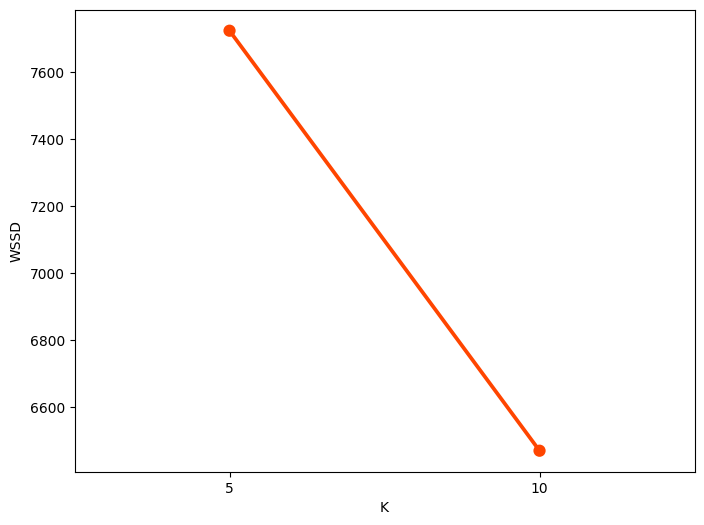

In [ ]:
plot_clustering_results(clustering_results)

In [ ]:
K=10 # Best value of K (whatever this is!)
print("Running K-means using K = {:d}".format(K))
model, clusters_df = k_means(tf_idf_df, K, max_iter=50, distance_measure="cosine")
clusters_df.cache()

Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  


DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector, features_norm: vector, cluster: int]

### Inspect some clusters

In [ ]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 1156|
|      1| 4183|
|      2|  321|
|      3| 1567|
|      4|  614|
|      5| 1096|
|      6| 1379|
|      7|  669|
|      8| 1370|
|      9| 1692|
+-------+-----+



In [ ]:
# Get unique values in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results
for x_id, x in enumerate(cluster_list):
  print("Showing the first 20 records of cluster ID #{:d}".format(x_id))
  x.select(["cluster", "Job title", "Salary range", "Location", "Tier", "Experience requirement", "Education requirements"]).show(20, truncate=False)

Cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Showing the first 20 records of cluster ID #0
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|cluster|Job title                                                                              |Salary range|Location |Tier                 |Experience requirement |Education requirements|
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|0      |big data statistics assistant wrapdouble break                                         |(B)[4K,8K)  |Shenzhen |First-tier cities    |(C)Experience unlimited|(B)Secondary Education|
|0      |data entry clerk                                                                       |(B)[4K,8K)  |Tianjin  |New first-tier cities|(C)Exper

# **Cluster Data Analysis**



### Show the first 10 most frequently occuring terms in each cluster

In [ ]:
for i, cluster_df in enumerate(cluster_list):
    print(f"Showing the highest 10 frequency terms for Cluster {i}")
    exploded_df = cluster_df.select(explode("terms").alias("words"))
    word_freq_df = exploded_df.groupBy("words").count().sort(desc("count"))
    word_freq_df = word_freq_df.limit(10)
    word_freq_df.show()

Showing the highest 10 frequency terms for Cluster 0
+----------+-----+
|     words|count|
+----------+-----+
|      data|  787|
|     clerk|  423|
|       one|  258|
|     entry|  219|
|     break|  205|
| insurance|  184|
|    double|  182|
|      gold|  181|
|         k|  180|
|statistics|  159|
+----------+-----+

Showing the highest 10 frequency terms for Cluster 1
+-----------+-----+
|      words|count|
+-----------+-----+
|       data| 3335|
|   engineer| 2979|
|development| 1618|
|        big| 1608|
|  operation|  367|
|     senior|  274|
|  architect|  202|
|   database|  187|
|  warehouse|  178|
| operations|  140|
+-----------+-----+

Showing the highest 10 frequency terms for Cluster 2
+-----------+-----+
|      words|count|
+-----------+-----+
|   software|  205|
|   engineer|  185|
|       data|  157|
|       test|  127|
|development|   72|
|        big|   63|
|    manager|   29|
|       java|   29|
|      sales|   28|
|     senior|   22|
+-----------+-----+

Showing the 

### Salary range analysis of jobs according to city tier system

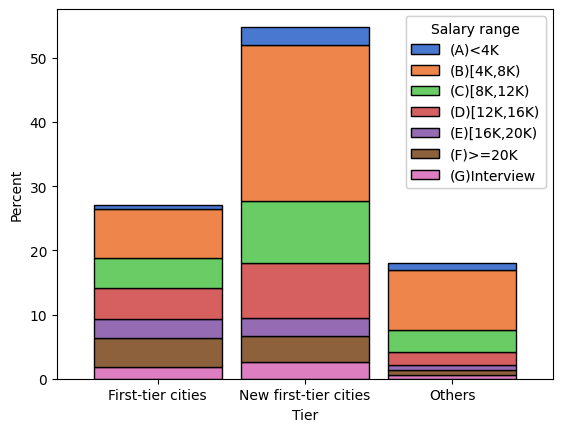

In [ ]:
display_df = clusters_df.toPandas()

grouped_df = display_df.groupby(['Tier', 'Salary range']).size().unstack().fillna(0)

percentage_df = (grouped_df/14047)*100
percentage_df = percentage_df[percentage_df.columns[::-1]]
original_palette = sns.color_palette("muted")
new_order = [6, 5, 4, 3, 2, 1, 0]
new_palette = [original_palette[i] for i in new_order]

sns.set_palette(new_palette)

ax = percentage_df.plot(kind='bar', stacked=True, width = 0.87, edgecolor='black')
ax.set_xticklabels(['First-tier cities','New first-tier cities','Others'], rotation=0)
ax.set_ylabel('Percent')

legend = plt.legend(title='Salary range')
handles, labels = plt.gca().get_legend_handles_labels()

handles = handles[::-1]
labels = labels[::-1]

reversed_legend = plt.legend(handles, labels, title='Salary range')

plt.gca().add_artist(reversed_legend)
plt.show()

### Proportions of jobs available in each cluster

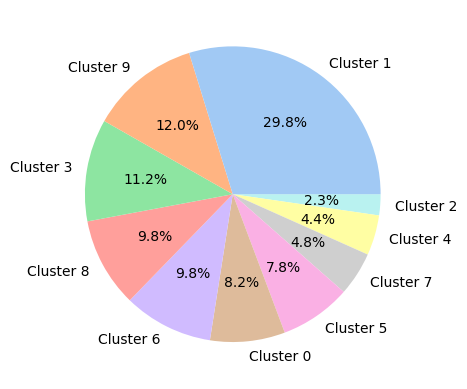

In [ ]:
pie_df = clusters_df.groupBy("cluster").count().sort("cluster")
pie_df = pie_df.toPandas()
i = 0
for index, row in pie_df.iterrows():
    pie_df.at[index, 'cluster'] = f'Cluster {i}'
    i = i + 1

for k in range(len(pie_df)):
    pie_df.loc[k, 'count'] = ((pie_df.loc[k, 'count'])/14047)*100
    pie_df.loc[k, 'count'] = np.round(pie_df.loc[k, 'count'], 1)

pie_df = pie_df.sort_values('count')

original_palette = sns.color_palette("pastel")
new_order = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
new_palette = [original_palette[i] for i in new_order]
sns.set_palette(new_palette)

plt.pie(pie_df['count'], labels=pie_df['cluster'], autopct='%1.1f%%', counterclock=False)
plt.show()

### Education requirements analysis of jobs in each cluster

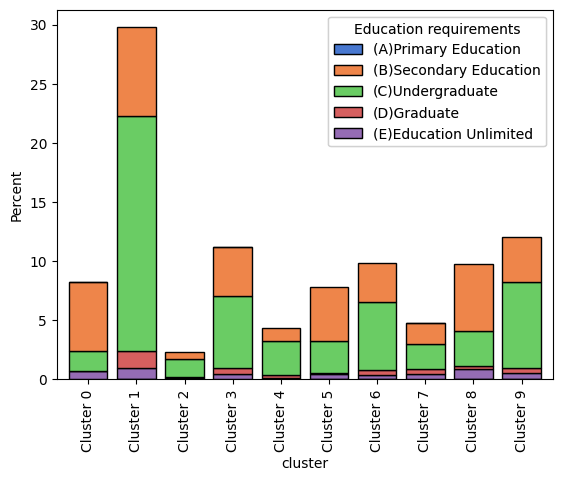

In [ ]:
df_total = pd.DataFrame()

for i in range(0, 10):

    df_grouped = cluster_list[i].groupBy("Education requirements").count().withColumnRenamed("count", f"Cluster {i}")
    group_transform = df_grouped.toPandas()
    group_transform.set_index("Education requirements", inplace=True)
    df_total = pd.concat([df_total, group_transform.T])

df_total = df_total.reindex(columns=['(A)Primary Education', '(B)Secondary Education', '(C)Undergraduate','(D)Graduate','(E)Education Unlimited'])
df_total = df_total.div(14047)
df_total = df_total * 100
df_total = df_total[df_total.columns[::-1]]

original_palette = sns.color_palette("muted")
new_order = [4, 3, 2, 1, 0]
new_palette = [original_palette[i] for i in new_order]
sns.set_palette(new_palette)
ax = df_total.plot(kind="bar", stacked=True,width = 0.8,edgecolor='black')

ax.set_xlabel("cluster")
ax.set_ylabel("Percent")

handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
reversed_legend = plt.legend(handles, labels, title='Education requirements')
plt.gca().add_artist(reversed_legend)

plt.show()

### Experience requirements analysis of jobs in each cluster

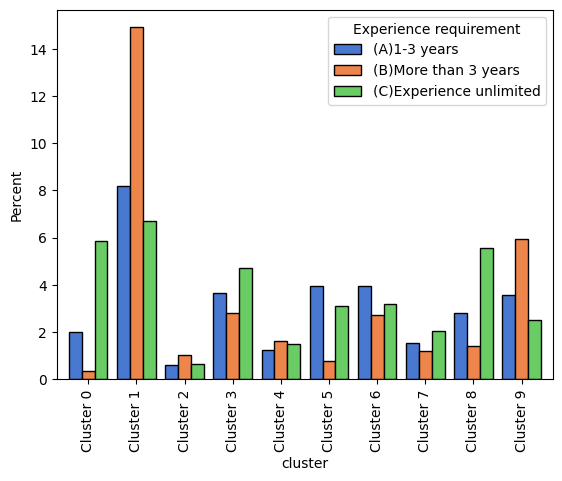

In [ ]:
df_total = pd.DataFrame()

for i in range(0, 10):

    df_grouped = cluster_list[i].groupBy("Experience requirement").count().withColumnRenamed("count", f"Cluster {i}")
    group_transform = df_grouped.toPandas()
    group_transform.set_index("Experience requirement", inplace=True)
    df_total = pd.concat([df_total, group_transform.T])

df_total = df_total.div(14047)
df_total = df_total * 100
col = df_total.pop('(A)1-3 years')
df_total.insert(0, '(A)1-3 years', col)
col = df_total.pop('(B)More than 3 years')
df_total.insert(1, '(B)More than 3 years', col)

sns.set_palette("muted")
ax = df_total.plot(kind="bar",edgecolor='black', width = 0.8)

ax.set_xlabel("cluster")
ax.set_ylabel("Percent")

plt.show()

When analysing the most frequent words in Cluster 1, the words "engineer," "senior," and "data" occur often. This indicates that most job applications within Cluster 1 are related to senior data engineering roles. Typically engineering jobs require more work experience due to the complexity of the work and the high level of responsibility required. The word "senior" also usually refers to someone with several years of work experience and who has gained all the necessary skills within a field. For these reasons, Cluster 1 has a high percentage of jobs requiring more than three years of work experience.

Cluster 9's most frequent words include "manager," "management," and "senior." These words indicate that most jobs within Cluster 9 are managerial positions within the data engineering profession. Due to the jobs being managerial positions, individuals experienced in a field are required because they have to be capable of leading a group and taking responsibility to ensure goals and tasks are completed on time and to the company's satisfaction. This increased responsibility and required industry knowledge means that individuals with more work experience are required. Thus, Cluster 9 has more jobs requiring more than three years of work experience.

### Salary range analysis of jobs in each cluster

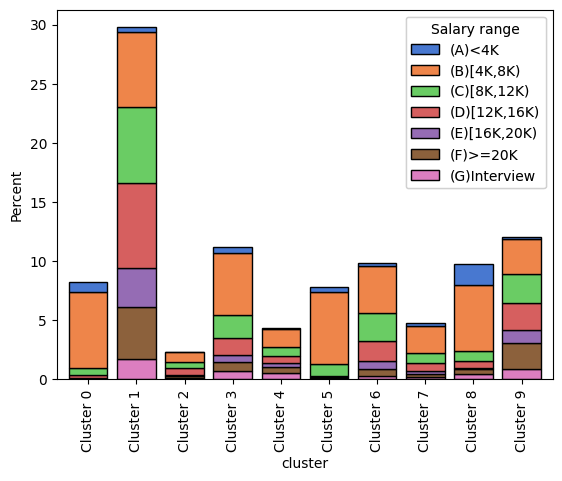

In [ ]:
df_total = pd.DataFrame()

for i in range(0, 10):

    df_grouped = cluster_list[i].groupBy("Salary range").count().withColumnRenamed("count", f"Cluster {i}")
    group_transform = df_grouped.toPandas()
    group_transform.set_index("Salary range", inplace=True)
    df_total = pd.concat([df_total, group_transform.T])

col = df_total.pop('(A)<4K')
df_total.insert(0, '(A)<4K', col)

df_total = df_total.div(14047)
df_total = df_total * 100
df_total = df_total[df_total.columns[::-1]]

original_palette = sns.color_palette("muted")
new_order = [6, 5, 4, 3, 2, 1, 0]
new_palette = [original_palette[i] for i in new_order]
sns.set_palette(new_palette)
ax = df_total.plot(kind="bar", stacked=True,width = 0.8,edgecolor='black')

ax.set_xlabel("cluster")
ax.set_ylabel("Percent")

handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
reversed_legend = plt.legend(handles, labels, title='Salary range')
plt.gca().add_artist(reversed_legend)

plt.show()

Cluster 1 and Cluster 9 have the highest salary ranges for a few reasons. When looking at the education requirements of these clusters, they have the highest percentage of undergraduate and graduate requirements. Typically, jobs requiring an individual to have studied toward a degree pay more due to the complexity of the work and the limited supply of people with the qualifications.
Both Cluster 1 and Cluster 9 also have the highest percentage of jobs requiring more than three years of work experience. Typically, jobs that require more work experience pay more money due to the employees being able to contribute more significantly towards the business and the jobs requiring a greater amount of responsibility.

By analysing the most frequent words in each of the clusters, it was observed that Cluster 1 contained a high number of senior data engineering-related jobs; while Cluster 9 contained a significant number of jobs related to management and senior roles. These types of jobs typically pay more due to their increased importance to a company and the high complexity of the work that has to be performed.

Thus, it can be concluded that Cluster 1 and Cluster 9 contain higher salary ranges due to a higher percentage of the jobs requiring a degree, more than three years of work experience, and the jobs being related to senior engineering or management roles.

The performance of a K-means text clustering model can be evaluated by analysing various metrics. The Silhouette coefficient measures how well the data has been separated into clusters, with values ranging between -1 and 1. The closer the score is to 1, the better the data has been separated. The Silhouette coefficient of the model trained in this notebook was 0.238, which is not optimal. The reason for the coefficient being low is that only 10 clusters were used when the variance of job applications was high. The low number of clusters being used meant that some jobs that were not similar were grouped, which reduced the usefulness of the data interpretation. To improve the Silhouette score and, thus, the model's performance, a greater number of clusters should be used to separate the data more accurately.

Any potential outliers within the dataset were not analysed during the preprocessing stage. Outliers within the data can negatively impact the performance of the clustering model because it struggles to group these entries and thus places them in a cluster where they do not belong. Identifying and removing the outliers would have improved the accuracy of the clustering and thus allowed for a better interpretation of the data.

To improve the clustering model further, Grid Search should be performed to find the best hyperparameters to set for the model. This process can be computationally demanding; however, it would improve the performance of the clustering.

The final method by which the clustering model could be improved is by implementing an ensemble method to increase the accuracy of the clustering. Using ensemble methods can reduce the effect of outliers or errors within the dataset and thus prevent these entries from affecting the performance.
